<a href="https://colab.research.google.com/github/shokru/carbon_emissions/blob/main/gdp_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Economic output and temperature dynamics

In [1]:
import pandas as pd                      # This library is for data wrangling
import seaborn as sns                    # This is one library for plotting
import matplotlib.pyplot as plt          # Yet another library for visualization
import plotly.express as px              # This is another library for plots 
import statsmodels.api as sm             # For the Granger causality test
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
pd.set_option('display.max_rows', 6)     # First 3 and last 3 rows will be shown
import warnings                          # This is to remove warning to keep output clean
warnings.filterwarnings('ignore')

## Temperature data

There are several sources for global temperatures. All in all, it seems that this does not matter much. As [Wikipedia](https://en.wikipedia.org/wiki/Global_temperature_record) notes: '*Global average temperature datasets from NASA, NOAA, Berkeley Earth, and meteorological offices of the U.K. and Japan, show substantial agreement concerning the progress and extent of global warming: pairwise correlations range from 98.09% to 99.04%.*'

First, let's download global annual temperatures from the **NASA** (see the page https://climate.nasa.gov/vital-signs/global-temperature/).  
The values related to the difference with **pre-industrial periods**.  
This is often taken to be 1850-1900, though it's unclear if this is the base choice in the NASA's data.

In full disclosure, we also mention the outstanding [tutorial](https://climateestimate.net/content/getting-started.html) from 4 climate & data researchers. It goes in much more depth and provides code both in R & Python.

In [2]:
url = 'https://data.giss.nasa.gov/gistemp/graphs/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.txt'
data_temp = pd.read_csv(url, skiprows = 4, sep='\r\t')  
data_temp = data_temp.iloc[0:,0].str.split(expand = True)
data_temp = data_temp.rename(columns = {0: 'Year', 1: 'Temperature', 2: 'Smoothing'})
data_temp['Temperature'] = pd.to_numeric(data_temp['Temperature']) # Translate to number
data_temp['Smoothing'] = pd.to_numeric(data_temp['Smoothing'])     # Translate to number
data_temp['Year'] = pd.to_numeric(data_temp['Year'])               # Translate to number
data_temp

,Year,Temperature,Smoothing
0,1880,-0.17,-0.10
1,1881,-0.09,-0.13
2,1882,-0.11,-0.17
...,...,...,...
140,2020,1.02,0.92
141,2021,0.85,0.91
142,2022,0.89,0.90


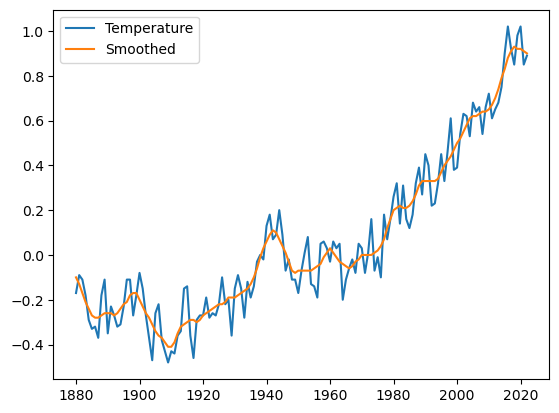

In [3]:
plt.plot(data_temp.Year, data_temp.Temperature, label = "Temperature")
plt.plot(data_temp.Year, data_temp.Smoothing, label = "Smoothed")
plt.legend()
plt.show()
plt.rcParams["figure.figsize"]=(10, 6)

The trend post-1960 seems pretty obvious (almost post-1900 if we omit World War II).

Next, GDP data from the **World Bank**.

In [4]:
url = 'https://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=excel'
data_gdp = pd.read_excel(url, skiprows = 3) 
# Putting the data in long format below
data_gdp = pd.wide_to_long(data_gdp.iloc[0:,0:65], 
                stubnames = [''], 
                i = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                j = 'Year').reset_index()
data_gdp = data_gdp.rename(columns = {'Country Name': 'Country', '': 'GDP'})
data_gdp

,Country,Country Code,Indicator Name,Indicator Code,Year,GDP
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,1960,NaN
1,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,1961,NaN
2,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,1962,NaN
...,...,...,...,...,...,...
16223,Zimbabwe,ZWE,GDP (current US$),NY.GDP.MKTP.CD,2018,3.415607e+10
16224,Zimbabwe,ZWE,GDP (current US$),NY.GDP.MKTP.CD,2019,2.183223e+10
16225,Zimbabwe,ZWE,GDP (current US$),NY.GDP.MKTP.CD,2020,2.150970e+10


Below: a quick look at all **geographical zones** included in the sample: lots of **clusters**!

In [5]:
data_gdp.Country.unique()

array(['Aruba', 'Africa Eastern and Southern', 'Afghanistan',
       'Africa Western and Central', 'Angola', 'Albania', 'Andorra',
       'Arab World', 'United Arab Emirates', 'Argentina', 'Armenia',
       'American Samoa', 'Antigua and Barbuda', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso',
       'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas, The',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan',
       'Botswana', 'Central African Republic', 'Canada',
       'Central Europe and the Baltics', 'Switzerland', 'Channel Islands',
       'Chile', 'China', "Cote d'Ivoire", 'Cameroon', 'Congo, Dem. Rep.',
       'Congo, Rep.', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica',
       'Caribbean small states', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czechia', 'Germany', 'Djibouti', 'Dominica', 'Denmark',
       'Dominican Republic', 'Algeria',
 

Since the temperature (from the NASA data) is measured worldwide, we need to focus only on the **World** subcategory (second-to-last row in the list).

Finally, let's join the two datasets.

In [6]:
temp_merge = data_temp.merge(data_gdp.query('Country == "World"'),
      left_on = 'Year', right_on = 'Year')
temp_merge

,Year,Temperature,Smoothing,Country,Country Code,Indicator Name,Indicator Code,GDP
0,1960,-0.03,0.03,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,1.392273e+12
1,1961,0.06,0.01,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,1.448622e+12
2,1962,0.03,-0.01,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,1.550544e+12
...,...,...,...,...,...,...,...,...
58,2018,0.85,0.93,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,8.646696e+13
59,2019,0.98,0.92,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,8.765425e+13
60,2020,1.02,0.92,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,8.511634e+13


Let's see how the trends compare from 1960 onwards.

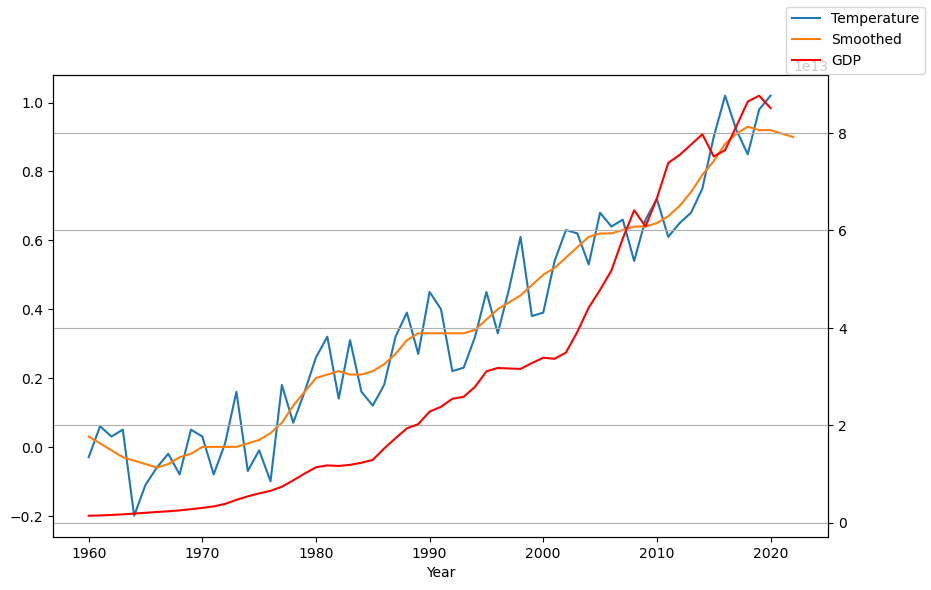

In [7]:
ax = temp_merge.plot(x = "Year", y = "Temperature", legend = False) 
plt.plot(data_temp.query('Year > 1959').Year, 
         data_temp.query('Year > 1959').Smoothing, 
         label = "Smoothed")
ax2 = ax.twinx()
temp_merge.plot(x = "Year", y = "GDP", ax = ax2, legend = False, color = "r")
ax.figure.legend()
plt.grid()
plt.show()
plt.rcParams["figure.figsize"]=(10, 6)

## Granger causality
### Definition

Causality is a complex notion. Clive Granger, who was awarded the Nobel Prize in Economics in 2003, proposed a simple, heuristic model to try to detect a weak form of causality in time-series.   
Suppose you are given two time-series, $y_t$ and $x_t$, where $t$ is the time index.  
One way to introduce a sense of memory in the model is to assume that $y_t$ depends on past values of the processes, i.e.,  

\begin{align}
y_t = a + \sum_{s=1}^pb_sy_{t-s}+ \sum_{r=1}^qd_rx_{t-r}+e_t.
\end{align}


In the above equation: 
- $a$ is some real number;
- the first sum represents a linear combination of past values of $y_t$, while 
- the second is a linear combination of the past values of $x_t$;
- $e_t$ is an error term: it is not always possible to represent $y_t$ as a simple double sum.   
Heuristically, it seems fair to assume that the variable (process) $x$ does not *influence* $y$ if all the coefficents $d_r$ are equal to zero. Basically, this means that $y$ cannot be explained with any past realization of $x_t$.  
Thus, we will say that $x$ **does not Granger-cause *y*** if $d_r=0$ for $r=1,...,q$.

### Empirical test
The test is implemented in the **statsmodels** python module.  
It performs 4 similar tests on whether the coefficients $d_r$ of $x$ in the above Equation are all equal to zero.


In [8]:
granger_test = grangercausalitytests(temp_merge[['Temperature', 'GDP']], maxlag = 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.4119 , p=0.0001  , df_denom=57, df_num=1
ssr based chi2 test:   chi2=19.3809 , p=0.0000  , df=1
likelihood ratio test: chi2=16.7948 , p=0.0000  , df=1
parameter F test:         F=18.4119 , p=0.0001  , df_denom=57, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.0920  , p=0.0018  , df_denom=54, df_num=2
ssr based chi2 test:   chi2=15.4974 , p=0.0004  , df=2
likelihood ratio test: chi2=13.7604 , p=0.0010  , df=2
parameter F test:         F=7.0256  , p=0.0019  , df_denom=54, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1896  , p=0.0310  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=10.4714 , p=0.0150  , df=3
likelihood ratio test: chi2=9.6264  , p=0.0220  , df=3
parameter F test:         F=3.2859  , p=0.0277  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5290  , p=0.2077  , df_d

Ok, so how do we interpret these numbers?  
In academia, it is customary to focus on the so-called **p-values** (the p=... in the output).    
The p-values are a measure of how likely the data is under the **null hypothesis**.  
Here, the null is that all coefficients pertaining to $x$ are equal to zero.  
When the lag (q) is equal to one, we see that the p-values are very small (0.0000), meaning that the dataset is improbable under the null. Rephrasing it (in a less rigorous way), it means that it's unlikely that the coefficients are equal to zero, and hence that GDP does **not not** cause the temperature series.    
When q=4, the p-values are higher (>0.15), and thus the sample is less unlikely. In this case, we cannot reject the null and Granger causality no longer holds.  
Naturally, it makes sense that it is harder to unveil causality because it requires ALL coefficients to be zero, which is a stringent assumption.   
For the sake of exhaustiveness, it is sometimes customary to perform the test the other way around. 

In [9]:
granger_test = grangercausalitytests(temp_merge[['GDP', 'Temperature']], maxlag = 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9719  , p=0.0177  , df_denom=57, df_num=1
ssr based chi2 test:   chi2=6.2862  , p=0.0122  , df=1
likelihood ratio test: chi2=5.9782  , p=0.0145  , df=1
parameter F test:         F=5.9719  , p=0.0177  , df_denom=57, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5552  , p=0.0354  , df_denom=54, df_num=2
ssr based chi2 test:   chi2=7.7688  , p=0.0206  , df=2
likelihood ratio test: chi2=7.2982  , p=0.0260  , df=2
parameter F test:         F=3.5552  , p=0.0354  , df_denom=54, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7875  , p=0.1607  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=5.8684  , p=0.1182  , df=3
likelihood ratio test: chi2=5.5902  , p=0.1333  , df=3
parameter F test:         F=1.7875  , p=0.1607  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4555  , p=0.2295  , df_d

Interestingly, the p-values are larger in this case, meaning that it is more likely that  
**GDP => temperature**  
than  
**temperature => GDP**  
(which makes sense, in a way).

## The long term perspective


The new GDP data is sourced from the Github account of **Our World in Data**, but the origin is the New Maddison Project Database and the World Bank.

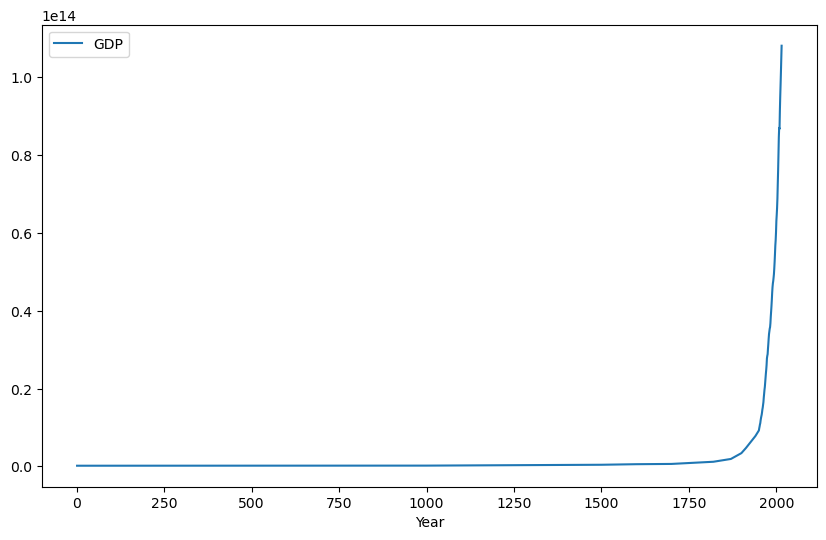

In [10]:
url ="https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/World%20GDP%20in%202011%20int%20%24%20%E2%80%93%20OWID%20based%20on%20World%20Bank%20%2B%20Maddison%20(2017)/World%20GDP%20in%202011%20int%20%24%20%E2%80%93%20OWID%20based%20on%20World%20Bank%20%2B%20Maddison%20(2017).csv"
gpd_lt = pd.read_csv(url)
gpd_lt.columns.values[2] = "GDP"
gpd_lt.plot(x = "Year", y = "GDP");

A long-term perspective shows the exponential nature of economic growth.  
Whether it is sustainable is still the topic of heated debates.  

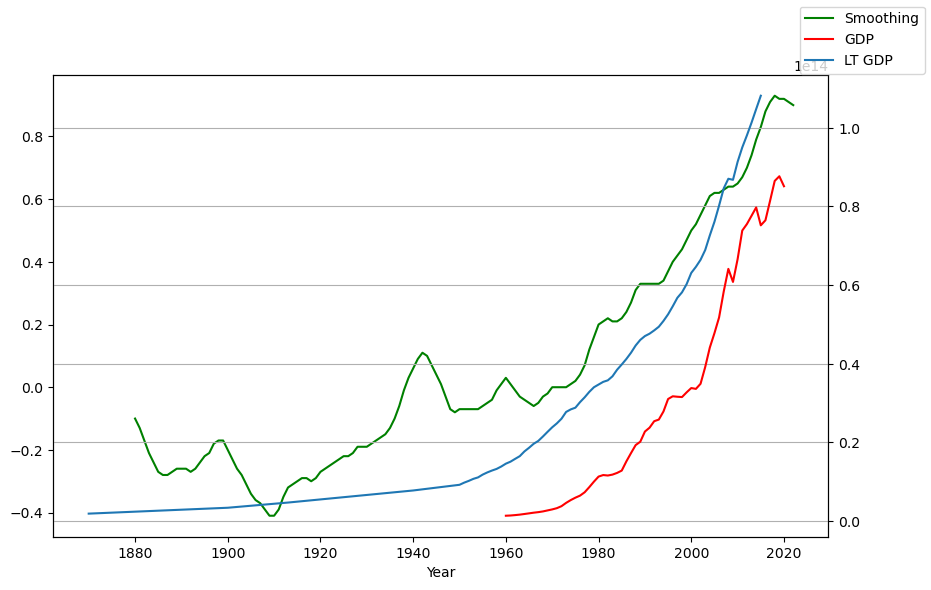

In [11]:
ax = data_temp.plot(x = "Year", y = "Smoothing", legend = False, color = 'g') 
ax2 = ax.twinx()
temp_merge.plot(x = "Year", y = "GDP", ax = ax2, legend = False, color = "r")
plt.plot(gpd_lt.query('Year > 1849').Year, 
         gpd_lt.query('Year > 1849').GDP, 
         label = "LT GDP")
ax.figure.legend()
plt.grid()
plt.show()
plt.rcParams["figure.figsize"]=(10, 6)

# Conclusion

Economic output and rising temperatures are **linked**. While our analysis is not sufficient to prove **causality**, there is strong consensus among the scientific community that global warming stems from human activity (even via cattle!).  
An important note: temperature is not the only relevant indicator. **Precipitation** (& humidity) is another facet of climate that is impacted by GHG emissions. The recent trends show extreme dynamics: dry places become drier and "wet" areas experience more and more intense rain episodes.